AUC: 0.8625913902764969
Sensitivity (Recall): 0.9321692411014103
Specificity: 0.537525354969574
Precision: 0.8589108910891089


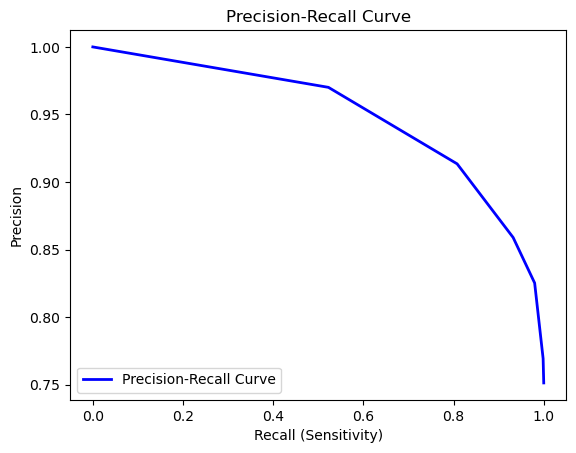

              precision    recall  f1-score   support

         0.0       0.72      0.54      0.62       493
         1.0       0.86      0.93      0.89      1489

    accuracy                           0.83      1982
   macro avg       0.79      0.73      0.76      1982
weighted avg       0.83      0.83      0.83      1982



In [153]:
import sklearn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
import missingno as msno
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
ipsilateral=pd.read_excel(r"/Users/williambray/Data/UnilateralCI_all(1).xlsx")
ipsilateral_df=prepare_dataset(ipsilateral)

In [92]:
print(ipsilateral_df['CNC candidate'].sum())

1489.0


In [97]:
ipsilateral_df.to_excel('Ipsilateral_check.xlsx', index=True)

<Axes: >

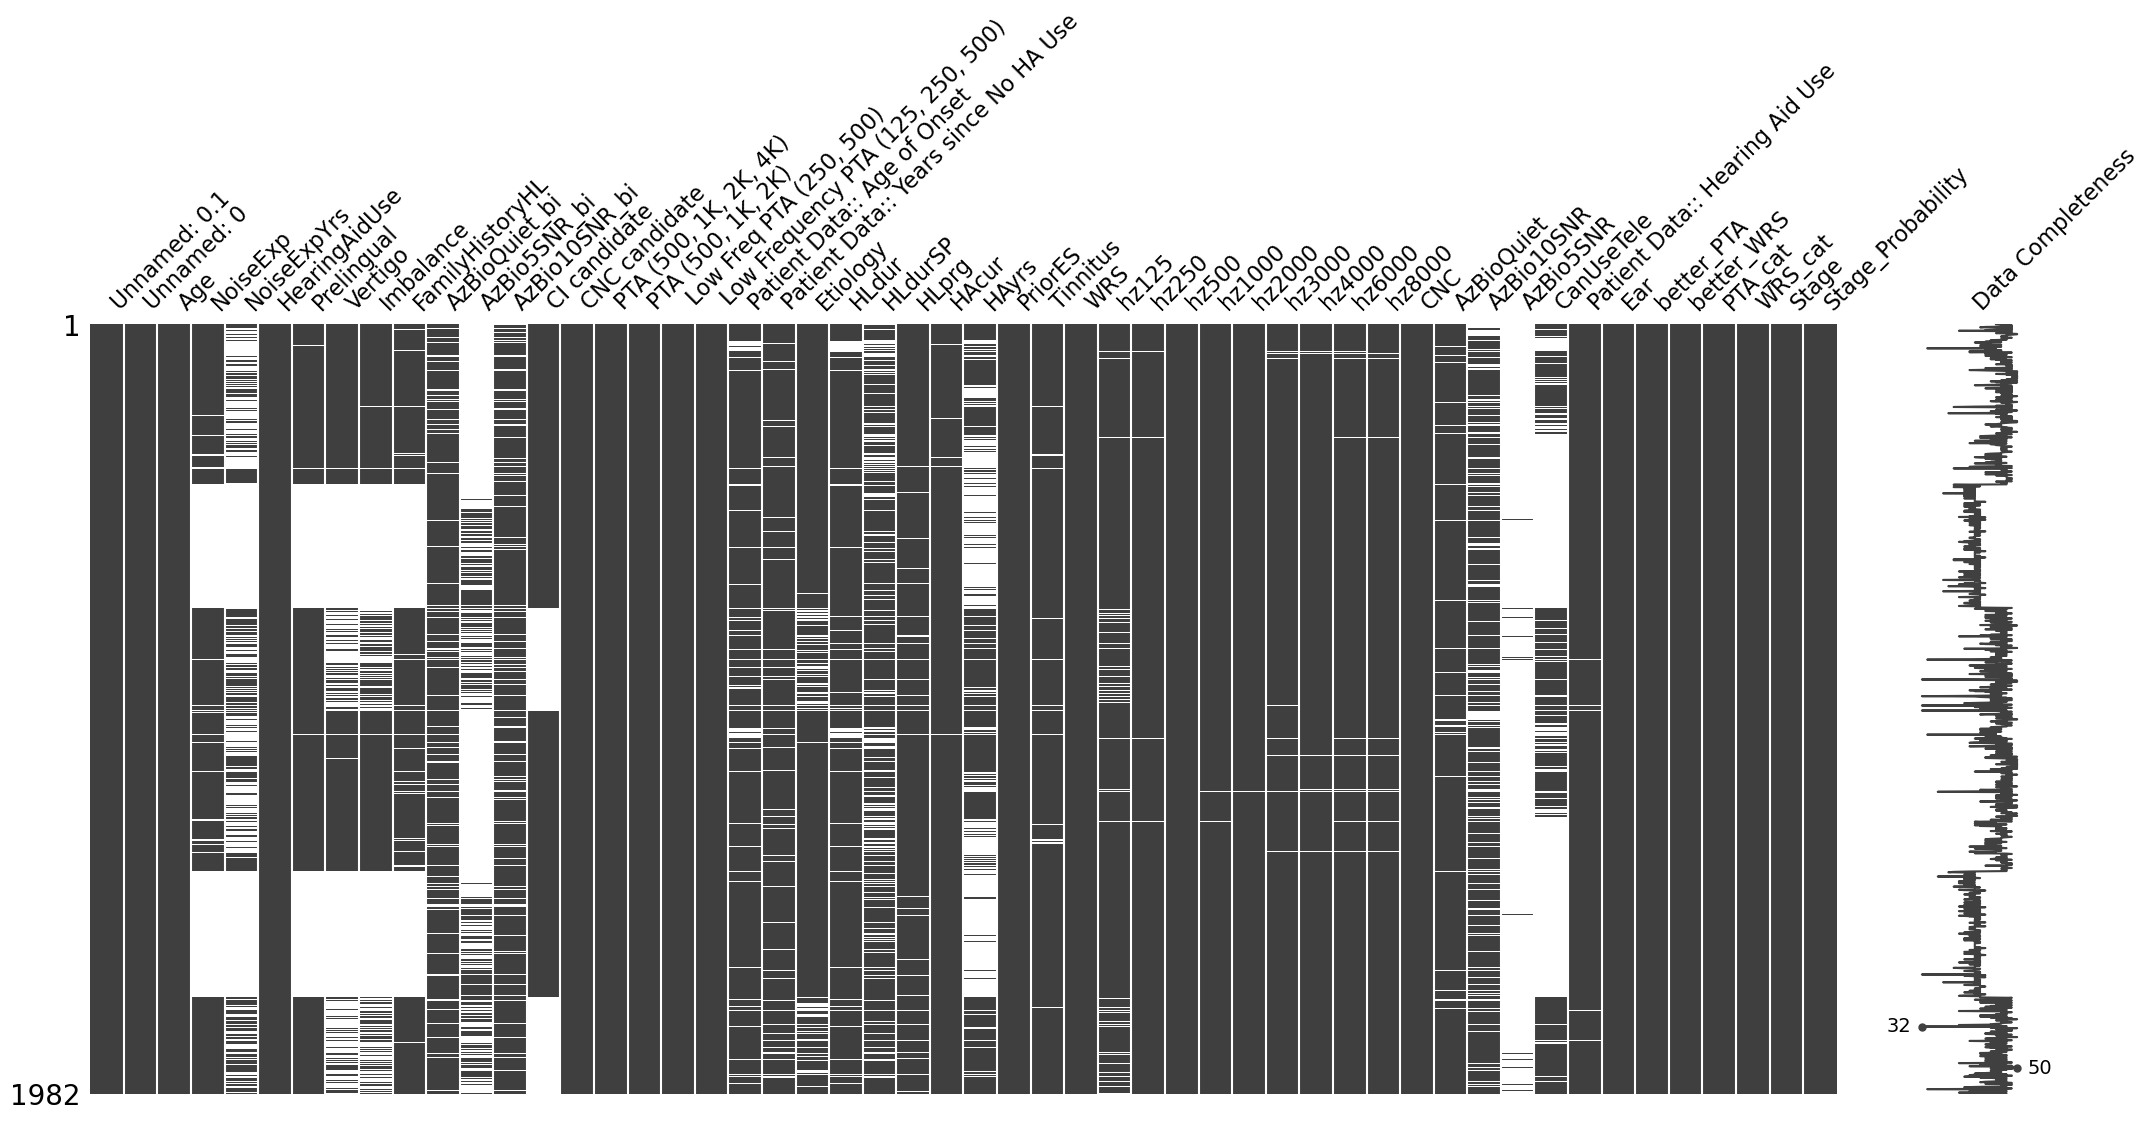

In [150]:
msno.matrix(ipsilateral_df, labels=True)

In [152]:
def prepare_dataset(df):
    df=better_val(df)
    df=categorize(df)
    df=CNC_cand(df)
    #df=CI_cand(df)
    df=PTA4Kfix(df)
    #df=CNC_simple_stages(df)
    df=CNC_complex_stages(df)
    df=prob_col(df)
    df=ROC(df)
    df=prc_curve(df)
    return df

In [65]:
def CNC_cand(df):
    used_col=['CNC','better_WRS','better_PTA']
    df=df.dropna(subset=used_col, how='any')
    df.loc[(df['CNC']<=40),'CNC candidate']=1
    df.loc[(df['CNC']>40),'CNC candidate']=0
    return df

In [66]:
def CI_cand(df):
    used_col=['better_WRS','better_PTA']
    df=df.dropna(subset=used_col, how='any')
    Azcol=['AzBioQuiet','AzBio10SNR']
    df=df.dropna(subset=Azcol, how='all')
    
    df.loc[(df['AzBio10SNR']<=60)|(df['AzBioQuiet']<= 60),'CI candidate']=1
    df['CI candidate']=df['CI candidate'].fillna(0)
    return df

In [67]:
def better_val(df):
    #for ipsilateral, better PTA is just PTA. Change here to manipulate what PTA values are used (2K, 4K, etc)
    df['better_PTA'] = df['PTA (500, 1K, 2K, 4K)']
    df['better_WRS'] = df['WRS']
    return df

In [142]:
def categorize(df):
    #original
#     conditions_pta = [
#          (df['better_PTA'] >= -5) & (df['better_PTA'] <= 40),
#          (df['better_PTA'] >= 41) & (df['better_PTA'] <= 60),
#          (df['better_PTA'] >= 61) & (df['better_PTA'] <= 80),
#          (df['better_PTA'] >= 81)
#     ]
#     categories_pta = [0, 1, 2, 3]
        
    #15 
    #    
    conditions_pta = [
         (df['better_PTA'] >= -5) & (df['better_PTA'] <= 45),
         (df['better_PTA'] >= 46) & (df['better_PTA'] <= 60),
         (df['better_PTA'] >= 61) & (df['better_PTA'] <= 75),
         (df['better_PTA'] >= 76) & (df['better_PTA'] <= 90),
         (df['better_PTA'] >= 91) & (df['better_PTA'] <= 105),
         (df['better_PTA'] >= 106)
     ]
    categories_pta=[0,1,2,3,4,5]
    #
        
    df['PTA_cat'] = np.select(conditions_pta, categories_pta, default=np.nan)
    #original
#     conditions_wrs = [
#          (df['better_WRS'] >= 66) & (df['better_WRS'] <= 100),
#          (df['better_WRS'] >= 46) & (df['better_WRS'] <= 65),
#          (df['better_WRS'] >= 26) & (df['better_WRS'] <= 45),
#          (df['better_WRS'] >= 0) & (df['better_WRS'] <= 25)
#      ]
#     categories_wrs = [0, 1, 2, 3]
    
    #10
    conditions_wrs = [
          (df['better_WRS'] >= 81) & (df['better_WRS'] <= 100),
          (df['better_WRS'] >= 71) & (df['better_WRS'] <= 80),
          (df['better_WRS'] >= 61) & (df['better_WRS'] <= 70),
          (df['better_WRS'] >= 51) & (df['better_WRS'] <= 60),
          (df['better_WRS'] >= 41) & (df['better_WRS'] <= 50),
          (df['better_WRS'] >= 31) & (df['better_WRS'] <= 40),
          (df['better_WRS'] >= 21) & (df['better_WRS'] <= 30),
          (df['better_WRS'] >= 11) & (df['better_WRS'] <= 20),
          (df['better_WRS'] >= 0) & (df['better_WRS'] <= 10),
      ]
    categories_wrs = [0,1,2,3,4,5,6,7,8]
        
    #15
#     conditions_wrs = [
#          (df['better_WRS'] >= 90) & (df['better_WRS'] <= 100),
#          (df['better_WRS'] >= 75) & (df['better_WRS'] <= 89),
#          (df['better_WRS'] >= 60) & (df['better_WRS'] <= 74),
#          (df['better_WRS'] >= 45) & (df['better_WRS'] <= 59),
#          (df['better_WRS'] >= 30) & (df['better_WRS'] <= 44),
#          (df['better_WRS'] >= 15) & (df['better_WRS'] <= 29),
#          (df['better_WRS'] >= 0) & (df['better_WRS'] <= 14),
#      ]
#     categories_wrs = [0,1,2,3,4,5,6]
        
        
    df['WRS_cat'] = np.select(conditions_wrs, categories_wrs, default=np.nan)
    return df

In [144]:
def conj_consol(df):
    row='WRS_cat'
    column='PTA_cat'
    total_counts = df.groupby([row, column]).size().reset_index(name='Total Count')
    candidate_counts = df[df['CNC candidate'] == 1].groupby([row, column]).size().reset_index(name='Candidate Count')
    merged_counts = pd.merge(total_counts, candidate_counts, on=[row, column], how='left')
    merged_counts['Candidate Count'] = merged_counts['Candidate Count'].fillna(0)
    merged_counts['Percentage'] = (merged_counts['Candidate Count'] / merged_counts['Total Count']) * 100
    merged_counts['Candidates / Total'] = merged_counts['Candidate Count'].astype(int).astype(str) + " / " + merged_counts['Total Count'].astype(int).astype(str)
    result_table = merged_counts.pivot(index=row, columns=column, values='Candidates / Total')
    row_sums = merged_counts.groupby(row)[['Candidate Count', 'Total Count']].sum().astype(int)
    row_sums['Candidates / Total'] = row_sums['Candidate Count'].astype(str) + " / " + row_sums['Total Count'].astype(str)
    col_sums = merged_counts.groupby(column)[['Candidate Count', 'Total Count']].sum().astype(int)
    col_sums['Candidates / Total'] = col_sums['Candidate Count'].astype(str) + " / " + col_sums['Total Count'].astype(str)
    result_table['Row Total'] = row_sums['Candidates / Total']
    col_total = pd.DataFrame(col_sums['Candidates / Total']).T
    col_total.index = ['Col Total']
    result_table = pd.concat([result_table, col_total])
    print(result_table)
conj_consol(ipsilateral_df)

PTA_cat       0.0       1.0        2.0        3.0        4.0        5.0  \
0.0        2 / 41    7 / 25     1 / 11      3 / 3      1 / 2        NaN   
1.0         0 / 4    1 / 22     7 / 28     7 / 10      2 / 2        NaN   
2.0         0 / 4    6 / 29    14 / 28     4 / 11        NaN      1 / 1   
3.0         1 / 4    5 / 45    34 / 69    16 / 24      5 / 6      1 / 2   
4.0         0 / 1   12 / 29    48 / 82    27 / 42    11 / 12      2 / 2   
5.0           NaN   10 / 23   79 / 125    49 / 57    23 / 25      6 / 6   
6.0           NaN   19 / 24    72 / 94    69 / 85    34 / 34      5 / 5   
7.0         0 / 1   18 / 26  106 / 121  115 / 123    55 / 59    11 / 11   
8.0         1 / 2    8 / 10    77 / 90  157 / 161  184 / 186  173 / 175   
Col Total  4 / 57  86 / 233  438 / 648  447 / 516  315 / 326  199 / 202   

PTA_cat    Row Total  
0.0          14 / 82  
1.0          17 / 66  
2.0          25 / 73  
3.0         62 / 150  
4.0        100 / 168  
5.0        167 / 236  
6.0        19

In [50]:
def fil(df):
    condition = (
    ((df['WRS'] >= 90) | 
    (df['PTA (500, 1K, 2K, 4K)'] <= 30))& 
    (df['CI candidate']==1)
    )

# Filter the dataframe based on the condition
    filtered_df = df[condition]

# Get the 'MRN' values from the filtered dataframe
    mrn_values = filtered_df['Unnamed: 0'].values

# Display the results
    print(mrn_values)
fil(ipsilateral_df)

[ 581  869 1201  254  326  713 1021 1239 1368  326  503  533]


In [90]:
def PTA4Kfix(df):
#     df['PTA (500, 1K, 2K, 4K)'] = df[['hz500', 'hz1000', 'hz2000', 'hz4000']].mean(axis=1)
#     df = df[df['PTA (500, 1K, 2K, 4K)'] >= 15]
    hz_columns = ['hz125', 'hz250', 'hz500', 'hz1000', 'hz2000', 'hz3000', 'hz4000', 'hz6000', 'hz8000']
    df = df[~(df[hz_columns] < 20).all(axis=1)]
    return df


In [117]:

etiology_percentages = ipsilateral_df['Ear'].value_counts(normalize=True) *100

# Display the result
print(etiology_percentages)


Ear
Left     50.25227
Right    49.74773
Name: proportion, dtype: float64


In [123]:
def CNC_simple_stages(df):
    stages = []
    for index, row in df.iterrows():
        PTA_cat = row['PTA_cat']
        WRS_cat = row['WRS_cat']
    
    # Stage 0
        if PTA_cat == 0 and WRS_cat == 0:
            stages.append(0)
    # Stage 1
        elif (PTA_cat == 0 and WRS_cat in [1,2,3]) or (PTA_cat == 1 and WRS_cat in [0,1])or (PTA_cat == 2 and WRS_cat==0):
            stages.append(1)
    # Stage 2
        elif (PTA_cat == 1 and WRS_cat==2) or (PTA_cat == 2 and WRS_cat == 1):
            stages.append(2)
    # Stage 3
        elif (PTA_cat == 1 and WRS_cat==3) or (PTA_cat == 2 and WRS_cat in [2, 3]) or (PTA_cat == 3 and WRS_cat in [0,1,2]):
            stages.append(3)
        elif (PTA_cat==3 and WRS_cat==3):
            stages.append(4)
        else:
            stages.append(None)
    df['Stage'] = stages
    return df

In [146]:
def CNC_complex_stages(df):
    stages = []
    for index, row in df.iterrows():
        PTA_cat = row['PTA_cat']
        WRS_cat = row['WRS_cat']
    
    # Stage 0
        if (PTA_cat == 0 and WRS_cat in [0,1,2]):
            stages.append(0)
    # Stage 1
        elif (PTA_cat == 0 and WRS_cat in [3,4]) or (PTA_cat == 1 and WRS_cat in [0,1,2,3]) or (PTA_cat==2 and WRS_cat in [0,1]):
            stages.append(1)
    # Stage 2
        elif (PTA_cat == 0 and WRS_cat in [7,8]) or (PTA_cat == 1 and WRS_cat in [4,5]) or (PTA_cat == 2 and WRS_cat in [2,3]):
            stages.append(2)
    # Stage 3
        elif (PTA_cat == 2 and WRS_cat in [4,5]) or (PTA_cat == 3 and WRS_cat in [0,1,2,3,4]) or (PTA_cat==4 and WRS_cat==0):
            stages.append(3)
        elif (PTA_cat == 1 and WRS_cat in [6,7,8]) or (PTA_cat == 2 and WRS_cat in [6,7,8]) or (PTA_cat == 3 and WRS_cat in [5,6])or (PTA_cat==4 and WRS_cat in [1,3]):
            stages.append(4)
        else:
            stages.append(5)
    df['Stage'] = stages
    return df

In [119]:
def prob_col(df):
    stage_probabilities = df.groupby('Stage')['CNC candidate'].mean().reset_index(name='Stage_Probability')
    df = pd.merge(df, stage_probabilities, on='Stage', how='left')
    return df

In [120]:
def ROC(df):
    true_labels = df['CNC candidate']
    predicted_probs = df['Stage_Probability']
    auc = roc_auc_score(true_labels, predicted_probs)
    print(f"AUC: {auc}")
    return df

In [151]:
def prc_curve(df):
    from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, roc_curve, auc

# True labels (0 or 1)
    true_labels = df['CNC candidate']

# Predicted probabilities (from your model)
    predicted_probs = df['Stage_Probability']

# Predicted labels based on a threshold (e.g., 0.5)
    predicted_labels = [1 if prob >= 0.5 else 0 for prob in predicted_probs]

# Confusion Matrix: [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

# Calculate Sensitivity, Specificity, and Precision
    sensitivity = tp / (tp + fn)  # True Positive Rate (Sensitivity or Recall)
    specificity = tn / (tn + fp)  # True Negative Rate (Specificity)
    precision = tp / (tp + fp)    # Precision

    print(f"Sensitivity (Recall): {sensitivity}")
    print(f"Specificity: {specificity}")
    print(f"Precision: {precision}")

# Precision-Recall Curve
    precision_vals, recall_vals, thresholds = precision_recall_curve(true_labels, predicted_probs)

# Plot Precision-Recall Curve
    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(recall_vals, precision_vals, lw=2, color='blue', label='Precision-Recall Curve')
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Optional: Full classification report for other metrics
    print(classification_report(true_labels, predicted_labels))
    return df

In [159]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Fit the ANOVA model
model = ols("ipsilateral_df['CNC candidate'] ~ ipsilateral_df['Stage']", data=ipsilateral_df).fit()

# Perform ANOVA
anova_table = anova_lm(model, typ=2)  # Type II ANOVA DataFrame

print(anova_table)

                             sum_sq      df            F         PR(>F)
ipsilateral_df['Stage']  137.683096     1.0  1171.575892  4.208315e-202
Residual                 232.688751  1980.0          NaN            NaN


In [164]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

def anova(df):
    true_labels = df['CNC candidate']
    predicted_probs = df['Stage_Probability']
    predicted_labels = [1 if prob >= 0.5 else 0 for prob in predicted_probs]
    model_preds = predicted_labels
    #78 is average CNC candidacy
    baseline_preds = np.full(len(true_labels), 0.78)
    data = pd.DataFrame({
        'true_label': true_labels,
        'model_prediction': model_preds,
        'baseline_prediction': baseline_preds
    })
    baseline_model = ols('true_label ~ baseline_prediction', data=data).fit()
    staging_model = ols('true_label ~ model_prediction', data=data).fit()
    anova_table = anova_lm(baseline_model, staging_model)
    ss_baseline = baseline_model.ssr  # Sum of squared residuals for the baseline model
    ss_model = staging_model.ssr      # Sum of squared residuals for your model
    
    ss_total = np.sum((true_labels - np.mean(true_labels))**2)
    ss_baseline_v = ss_total - baseline_model.ssr  # Total variance minus residuals from baseline model
    ss_model_v = ss_total - staging_model.ssr      # Total variance minus residuals from your model
    prv = (ss_model_v - ss_baseline_v) / ss_total
    anova_table = anova_lm(baseline_model, staging_model)
    anova_table['PRV'] = prv

    pre = (ss_baseline - ss_model) / ss_baseline
    anova_table['PRE'] = pre
    print(anova_table)
anova(ipsilateral_df)

   df_resid         ssr  df_diff     ss_diff    F  Pr(>F)       PRV       PRE
0    1980.0  370.371847      0.0         NaN  NaN     NaN  0.273811  0.273811
1    1980.0  268.960098     -0.0  101.411748 -inf     NaN  0.273811  0.273811


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.api import Logit
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
def anova2(df):
    true_labels = df['CNC candidate']
    predicted_probs = df['Stage_Probability']
    predicted_labels = [1 if prob >= 0.5 else 0 for prob in predicted_probs]

    # Assuming 78% candidacy rate as baseline prediction
    baseline_preds = np.full(len(true_labels), 0.78)

    # Create a dataframe to store true labels, model predictions, and baseline predictions
    data = pd.DataFrame({
        'true_label': true_labels,
        'model_prediction': predicted_labels,
        'baseline_prediction': baseline_preds
    })

    # Logistic Regression Model for Binary Data
    baseline_model = Logit(data['true_label'], data['baseline_prediction']).fit(disp=0)
    staging_model = Logit(data['true_label'], data['model_prediction']).fit(disp=0)

    # Calculate log-likelihood for each model
    ll_baseline = baseline_model.llf  # Log-likelihood for baseline model
    ll_staging = staging_model.llf    # Log-likelihood for staging model

    # Total sum of squares: variance of the actual true labels (binary case)
    ss_total = np.sum((true_labels - np.mean(true_labels))**2)

    # Proportionate Reduction in Error (PRE)
    pre = (ll_baseline - ll_staging) / ll_baseline

    # Proportionate Reduction in Variance (PRV)
    prv = (ll_staging - ll_baseline) / ss_total
    print(f"Proportionate Reduction in Error (PRE): {pre:.4f}")
    print(f"Proportionate Reduction in Variance (PRV): {prv:.4f}")

anova2(ipsilateral_df)

In [ ]:
print(ipsilateral_df['PTA (500, 1K, 2K, 4K)'].mean())
